# Common Risk Factors in Cryptocurrency

# Master Thesis Project

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0</div>

This file requires `pandas`, `datetime`, `numpy`, `wand`, `pdf2image`, `Pillow`, and `math` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment.

The project follows closely the methodology proposed by Liu, Tsyvinski, and Wu (2022) in their paper titled [Common Risk Factors in Cryptocurrency](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13119). Researchers and practitioners can use this paper to check the results of the paper and perhaps retrieve an updated version of the basic findings. They can also use it as a toolbox to use for other projects or to run an extended analysis including further risk factors. Finally, asset management firm may use this code to assess the risk of their portfolio or to firm anomalies in the returns of cryptocurrencies.

For this analysis, I occasionally had to make assumption, for example, regarding the procedure to convert daily to weekly data. This is especially so because the authors of the paper did not provide a detailed enough description of their decisions. There are other, perhabs better ways of doing certain steps and I am always grateful for any feedback that you might provide.

The order of the following sections is closely following the structure of the paper. The outline is:
* <a href="#I._Data">I. Data</a>: The files for all data sources can be found in the data folder. The main blockchain trading data is retrieved from CoinGecko (coingecko_data.py). It is advisable to download the cryptocurrency data set in smaller chunks (for example, 100 cryptocurrencies), since the data set is relatively large and takes long to download due to the API limit. The merge_data.py file can then be used to merge all individal cryptocurrency data files into one large file that is supposed to be loaded into the code below. The daily crptocurrency (aka coin) data is converted to weekly returns using the last available prices: $$r_t = \frac{p_t-p_{t-1}}{p_{t-1}}$$ One can also compute log-returns instead. The definition of the weeks is as follows: The first 7 days of a given year are the first week. The following 50 weeks consist of 7 days each. The last week has either 8 or 9 days (if the year is a leap year). The code below computes the weekly trading data (inclduing returns) and the weekly market returns. Moreover, it generates the first table of the paper. Consequently, 3 time series graphs plotting the returns of Bitcoin, Ripple, and Ethereum against the market returns is shown.

* <a href="#II._Cross-Sectional_Return_Predictor">II. Cross-Sectional Return Predictors</a>:
    * <a href="#A._Size_Characteristics">A. Size Characteristics</a>:
    * <a href="#B._Momentum_Characteristics">B. Momentum Characteristics</a>:
    * <a href="#C._Volume_Characteristics">C. Volume Characteristics</a>:
    * <a href="#D._Volatility_Characteristics">D. Volatility Characteristics</a>:
    * <a href="#E._Insignificant_Strategies">E. Insignificant Strategies</a>:

<a id="I._Data"></a> 
# I. Data

In [4]:
import pandas as pd, numpy as np, math, time, os, datetime as dt, data.coingecko_data as coingecko_data, helpers
pd.options.mode.chained_assignment = None
from wand.image import Image

# specify the data range for the analysis
# in the paper, the authors start on 2014-01-01 due to data availability
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("today")

# select the path to the directory where you want to store the data
directory = r"/Users/Marc/Desktop/Past Affairs/Past Universities/SSE Courses/Master Thesis/Data"

# downloading the data from CoinGecko.com and storing it in smaller data subsets at the specified location
# the data contains daily prices, market caps, and trading volumes
# this step can take up to 2 days due to the API traffic limit
# we are also always checking if the subsequent files already exist (/cg_data.csv, /cg_weekly_data.csv, /cg_weekly_returns.csv, /market_weekly_returns.csv)
# this helps in case the previous files have been deleted
files = ["/coingecko", "/cg_data.csv", "/cg_weekly_returns_data.csv", "/market_weekly_returns.csv"]
if any(os.path.exists(directory + file) for file in files):
    # if at least 1 file already exists
    print("The individual data files already exist.")
else:
    # if the file or the subsequent files do not already exist
    coingecko_data.retrieve_data(start_date, end_date, path=directory)

# merging the data subsets and storing the result at the specified location
# this task also absorbs part of the preprocessing, so it's recommended to run this step in any case 
# this step can take long
if any(os.path.exists(directory + file) for file in files[1:]):
    # if at least 1 file already exists
    print("The data was already merged into a single file.")  
else:
    # if the file or the subsequent files do not already exist
    helpers.merge_data(path=directory)  

# the data was retrieved on 2023-01-13
daily_trading_data = pd.read_csv(directory+"/cg_data.csv", index_col=["date"])

# downloading the data since the conversion process might also take a long time
if any(os.path.exists(directory + file) for file in files[2:]):
    # if at least 1 file already exists
    print("The data has already been converted.")
    weekly_returns_data = pd.read_csv(directory + "/cg_weekly_returns_data.csv", index_col=["date"])
else:
    # this function converts the frequency and also computes the retunrs series
    weekly_returns_data = helpers.convert_frequency(daily_trading_data, method="last", returns=True)
    # downloading the data
    weekly_returns_data.to_csv(directory + "/cg_weekly_returns_data.csv")    

# downloading the data since the returns computation process might also take a long time
if any(os.path.exists(directory + file) for file in files[3:]):
    # if at least 1 file already exists
    print("The market returns data has already been computed.")
    market_weekly_returns = pd.read_csv(directory + "/market_weekly_returns.csv", index_col=["date"])
else:
    # group the data by date
    grouped = weekly_returns_data.groupby(weekly_returns_data.index)
    # Compute the weighted average of the returns using the market capitalization as the weight
    market_weekly_returns = grouped.apply(lambda x: (x["return"]*x["market_cap"]).sum()/x["market_cap"].sum())
    # filling in the missing values with NaNs
    date_range = pd.date_range(start=min(weekly_returns_data.index), end=max(weekly_returns_data.index), freq='D')
    market_weekly_returns = market_weekly_returns.reindex(date_range)
    # downloading the data
    market_weekly_returns.to_csv(directory + "/market_weekly_returns.csv")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
# we need also the daily data since Panel A is built on daily data
# this step takes about 1 hour
helpers.render_summary_statistics(start_date, end_date, daily_trading_data, market_weekly_returns, weekly_returns_data, invert=invert)

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

The individual data files already exist.


AttributeError: module 'helpers' has no attribute 'merge_data'

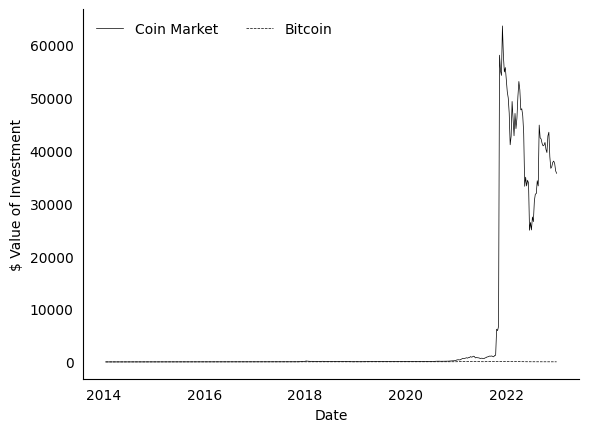

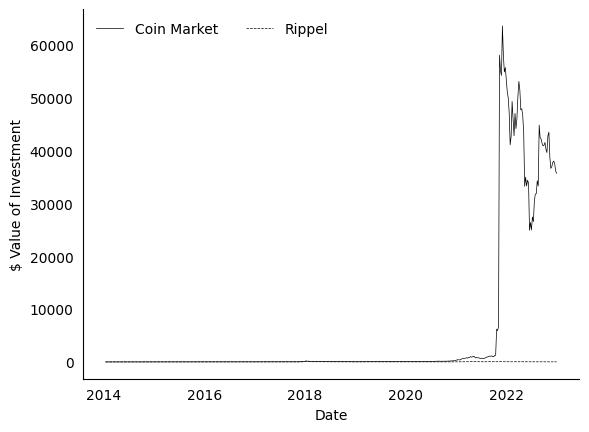

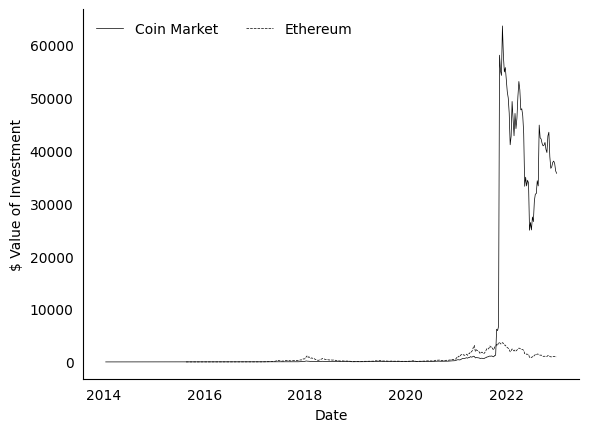

Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.


In [17]:
# plotting the time series graphs
import matplotlib.pyplot as plt, datetime, numpy as np, math

bitcoin_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "bitcoin"]
ripple_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ripple"]
ethereum_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ethereum"]

# %U assumes Monday as first day of the week
year_and_week = market_weekly_returns["year"].astype(int) + market_weekly_returns["week"].astype(int) / 52

market_weekly_returns["market_index"] = (1 + market_weekly_returns["average_return"]).cumprod()
# Set the first value of return_index to 1
market_weekly_returns.iloc[0,1] = 1
# imputing missing index values with the last non-missing value
market_weekly_returns["market_index"] = market_weekly_returns["market_index"].fillna(method='ffill')
market_index = market_weekly_returns["market_index"].tolist()

bitcoin_weekly_returns["bitcoin_index"] = (1 + bitcoin_weekly_returns["return"]).cumprod()
bitcoin_weekly_returns.iloc[0,1] = 1
bitcoin_weekly_returns["bitcoin_index"] = bitcoin_weekly_returns["bitcoin_index"].fillna(method='ffill')
bitcoin_index = bitcoin_weekly_returns["bitcoin_index"].tolist()

ripple_weekly_returns["ripple_index"] = (1 + ripple_weekly_returns["return"]).cumprod()
ripple_weekly_returns.iloc[0,1] = 1
ripple_weekly_returns["ripple_index"] = ripple_weekly_returns["ripple_index"].fillna(method='ffill')
ripple_index = ripple_weekly_returns["ripple_index"].tolist()

ethereum_weekly_returns["ethereum_index"] = (1 + ethereum_weekly_returns["return"]).cumprod()
ethereum_weekly_returns.iloc[0,1] = 1
ethereum_weekly_returns["ethereum_index"] = ethereum_weekly_returns["ethereum_index"].fillna(method='ffill')
ethereum_index = ethereum_weekly_returns["ethereum_index"].tolist()

vars = [bitcoin_index, ripple_index, ethereum_index]
labels = ["Bitcoin", "Rippel", "Ethereum"]
# max = [41, 151, 501]
max = [10000, 10000, 10000]
step_size = [10, 50, 100]

for i in range(3):
    plt.plot(year_and_week, np.array(market_index), color="black", label="Coin Market", linewidth=0.5)
    plt.plot(year_and_week, np.array(vars[i]), color="black", linestyle="dashed", label = labels[i], linewidth=0.5)
    plt.tick_params(color="white")
    # plt.yticks(np.arange(0, max[i], step_size[i]))
    plt.xticks(np.arange(int(start_date[:4]), int(end_date[:4]) + 1, 2))
    plt.xlabel("Date")
    plt.ylabel("$ Value of Investment")
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.legend(frameon=False, prop={"size": 10}, loc="upper left", ncol=2)
    plt.show()
print("Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.")


<a id="II._Cross-Sectional_Return_Predictor"></a>
# II. Cross-Sectional Return Predictor

<a id="A._Size_Characteristics"></a>
## A. Size Characteristics

In [23]:
# computing the zero-investment long-short strategies based on the size-related characteristics of market capitalization, price, maximum day price, and age
import data.fred_data as fred_data, helpers

# computing the risk-free rate
# a pd dataframe with columns for date and DGS1MO
risk_free_rate = fred_data.retrieve_data(start_date, end_date, series_ids = ["DGS1MO"], download=False)
date_range = pd.date_range(start=min(weekly_returns_data.index), end=max(weekly_returns_data.index), freq="D")
# making sure all days are in table
risk_free_rate = risk_free_rate.reindex(date_range)
# converting to weekly data
risk_free_rate = risk_free_rate.resample("W-SUN").last()


# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(directory + "/long_short_data_size.csv"):
    print("Computing the excess long-short strategies for the different size characteristics.")
    # creating the data for the size characteristics in coins_weekly_returns
    # adding log_market_cap
    weekly_returns_data["log_market_cap"] = np.log(weekly_returns_data["market_cap"])
    # adding log_price
    weekly_returns_data["log_price"] = np.log(weekly_returns_data["price"])
    # adding log_max_price
    coin_max_data = helpers.convert_frequency(daily_trading_data, method="max")
    weekly_returns_data["log_max_price"] = np.log(coin_max_data["price"])
    # adding age as the number of days listed since the first trading day of that respective coin (considering that the time period begins on 2014-01-01)

    dfs = []
    grouped = weekly_returns_data.groupby(weekly_returns_data["coin_id"])
    for group in grouped.groups:
        group = grouped.get_group(group)
        first_valid_index = group["return"].first_valid_index()
        group["age"] = (group.index - first_valid_index).days
        # we need to reindex to add back the missing value
        date_range = pd.date_range(start=min(weekly_returns_data.index), end=max(weekly_returns_data.index), freq="W")
        group = group.reindex(date_range)
        dfs.append(group)
    
    weekly_returns_data = pd.concat(dfs)

    # "risk_free_rate" now is a pd dataframe with columns for date and DGS1MO (the risk-free rate)
    long_short_data = risk_free_rate
    size_characteristics = ["log_market_cap", "log_price", "log_max_price", "age"]
    for size_characteristic in size_characteristics:
        quintile_returns_data = helpers.quintile_returns(size_characteristic, weekly_returns_data)
        for quintile in quintile_returns_data.keys():
            # computing the excess returns
            long_short_data[size_characteristic + "_" + quintile + "_quintile_return"] = quintile_returns_data[quintile] - long_short_data["DGS1MO"] / 100
        # computing the excess returns for the long-short strategy
        long_short_data[size_characteristic + "_excess_ls"] = long_short_data[size_characteristic + "_fifth_quintile_return"] - long_short_data[size_characteristic + "_first_quintile_return"] - long_short_data["DGS1MO"] / 100

    # downloading the data
    long_short_data.to_csv(directory + "/long_short_data_size.csv")
else:
    # next, we need to load the data and "unwrap" it again
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    long_short_data = pd.read_csv(directory + "/long_short_data_size.csv", index_col=["date"])

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# use "\symbol{37}" in the latex file for the percentage sign
helpers.render_size_strategy_returns(long_short_data, invert=invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

Count total NaN at each column in a dataframe:

 date        0
DGS1MO    945
dtype: int64
0.0890359878540039
3.7183449268341064
Empty DataFrame
Columns: [year, week, DGS1MO]
Index: []


ValueError: 

In [ ]:
# computing the zero-investment long-short strategies based on the size-related characteristics of market capitalization, price, maximum day price, and age
import data.fred_data as fred_data, time, helpers

# computing the risk-free rate
# a pd dataframe with columns for date and DGS1MO
risk_free_rate = fred_data.retrieve_data(start_date, end_date, series_ids = ["DGS1MO"], download=False)
risk_free_rate1 = risk_free_rate.copy()
# converting to weekly data
start = time.time()
risk_free_rate1["date"] = pd.to_datetime(risk_free_rate1["date"])
risk_free_rate1.set_index("date", inplace=True)
risk_free_rate1 = risk_free_rate1.resample("W-SUN").last()
end = time.time()
print(end - start)
start = time.time()
risk_free_rate = helpers.convert_to_weekly_frequency(risk_free_rate, start_date, end_date, download=False)
end = time.time()
print(end - start)

print(risk_free_rate.head())
raise ValueError

# function for the zero-investment long-short strategy
# it returns a list for the returns of the top 20% and the bottom 20% of a given characteristic
def quintile_returns(size_characteristic):
    first_quintile_returns = []
    second_quintile_returns = []
    third_quintile_returns = []
    fourth_quintile_returns = []
    fifth_quintile_returns = []
    # initializing the list of included coins
    first_quintile_coins = []
    second_quintile_coins = []
    third_quintile_coins = []
    fourth_quintile_coins = []
    fifth_quintile_coins = []
    # taking an arbitrary ID to loop through all weeks
    for i in coins_weekly_returns[coin_ids[0]].index:
        year = coins_weekly_returns[coin_ids[0]]["year"][i]
        week = coins_weekly_returns[coin_ids[0]]["week"][i]
        if year == 2014 and week == 1:
            # in the first week we have no quintile data (and also no return data)
            first_quintile_returns.append(np.nan)
            second_quintile_returns.append(np.nan)
            third_quintile_returns.append(np.nan)
            fourth_quintile_returns.append(np.nan)
            fifth_quintile_returns.append(np.nan)
        else:
            # computing the returns for the quintiles
            for quintile in ["first", "second", "third", "fourth", "fifth"]:
                match quintile:
                    case "first":
                        coins = first_quintile_coins
                    case "second":
                        coins = second_quintile_coins
                    case "third":
                        coins = third_quintile_coins
                    case "fourth":
                        coins = fourth_quintile_coins
                    case "fifth":
                        coins = fifth_quintile_coins
                returns = []
                market_caps = []
                for coin_id in coins:
                    coin_weekly_returns = coins_weekly_returns[coin_id]
                    coin_weekly_data = coin_weekly_returns[(coin_weekly_returns["year"] == year) & (coin_weekly_returns["week"] == week)]
                    # ignoring all NaNs
                    # the most convenient way to check if no cell value are NaN is by applying .isna().sum().sum()
                    if coin_weekly_data.isna().sum().sum() == 0:
                        returns.append(coin_weekly_data["return"].tolist()[0])
                        market_caps.append(coin_weekly_data["market_cap"].tolist()[0])
                # if all returns are NaN (for example, in the first week of the time period considered)
                if len(returns) == 0:
                    # if no value was added
                    match quintile:
                        case "first":
                            first_quintile_returns.append(np.nan)
                        case "second":
                            second_quintile_returns.append(np.nan)
                        case "third":
                            third_quintile_returns.append(np.nan)
                        case "fourth":
                            fourth_quintile_returns.append(np.nan)
                        case "fifth":
                            fifth_quintile_returns.append(np.nan)
                else:
                    # for every week add the value-weighted market return (the sumproduct of the returns and the market caps divided by the sum of the market caps) and the included coin IDs
                    weighted_average = (sum(x * y for x, y in zip(returns, market_caps)) / sum(market_caps))
                    match quintile:
                        case "first":
                            first_quintile_returns.append(weighted_average)
                        case "second":
                            second_quintile_returns.append(weighted_average)
                        case "third":
                            third_quintile_returns.append(weighted_average)
                        case "fourth":
                            fourth_quintile_returns.append(weighted_average)
                        case "fifth":
                            fifth_quintile_returns.append(weighted_average)

        # computing quintiles for the next week 
        characteristic_data = []
        coin_ids_copy = coin_ids.copy().tolist()
        for coin_id in coin_ids:
            # the size characteristic for every coin
            characteristic_data = coins_weekly_returns[coin_id][(coins_weekly_returns[coin_id]["year"] == year) & (coins_weekly_returns[coin_id]["week"] == week)][size_characteristic]
            if not pd.isna(characteristic_data.tolist()[0]):
                characteristic_data.append(characteristic_data.tolist()[0])
            else:
                # ignoring all coins with missing values
                coin_ids_copy.remove(coin_id)
        # finding the coin ids of the top and bottom 20% market cap coins
        characteristic_data = pd.DataFrame({"coin_id": coin_ids_copy, size_characteristic: characteristic_data})
        first_quintile = characteristic_data.quantile(q=0.2, interpolation="nearest").tolist()[0]
        second_quintile = characteristic_data.quantile(q=0.4, interpolation="nearest").tolist()[0]
        third_quintile = characteristic_data.quantile(q=0.6, interpolation="nearest").tolist()[0]
        fourth_quintile = characteristic_data.quantile(q=0.8, interpolation="nearest").tolist()[0]
        # and the according coins
        first_quintile_coins = characteristic_data["coin_id"][characteristic_data[size_characteristic] <= first_quintile].tolist()
        second_quintile_coins = characteristic_data["coin_id"][(characteristic_data[size_characteristic] > first_quintile) & (characteristic_data[size_characteristic] <= second_quintile)].tolist()
        third_quintile_coins = characteristic_data["coin_id"][(characteristic_data[size_characteristic] > second_quintile) & (characteristic_data[size_characteristic] <= third_quintile)].tolist()
        fourth_quintile_coins = characteristic_data["coin_id"][(characteristic_data[size_characteristic] > third_quintile) & (characteristic_data[size_characteristic] <= fourth_quintile)].tolist()
        fifth_quintile_coins = characteristic_data["coin_id"][characteristic_data[size_characteristic] > fourth_quintile].tolist()

    return {"first": first_quintile_returns, "second": second_quintile_returns, "third": third_quintile_returns, "fourth": fourth_quintile_returns, "fifth": fifth_quintile_returns}

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(directory + "/long_short_data_size.csv"):
    print("Computing the excess long-short strategies for the different size characteristics.")

    # creating the data for the size characteristics in coins_weekly_returns
    for coin_id in coin_ids:
        coin_weekly_returns = coins_weekly_returns[coin_id]
        # adding log_market_cap
        coin_weekly_returns["log_market_cap"] = np.log(coin_weekly_returns["market_cap"])
        # adding log_price
        coin_weekly_returns["log_price"] = np.log(coin_weekly_returns["price"])
        # adding log_max_price
        coin_daily_trading_data = daily_trading_data[daily_trading_data["id"] == coin_id]
        # these columns have already been checked
        coin_daily_trading_data = coin_daily_trading_data.drop(columns=["id", "market_cap", "total_volume"])
        coin_max_data = helpers.convert_to_weekly_frequency(coin_daily_trading_data, start_date, end_date, mode="max_day", download=False)
        coin_weekly_returns["log_max_price"] = np.log(coin_max_data["price"])
        # adding age as the number of days listed since the first trading day of that respective coin (considering that the tiem period befin on 2014-01-01)
        age = []
        for i in coin_weekly_returns.index:
            first_date_found = False
            # the number of days to the date of the first price determines the age
            if pd.isna(coin_weekly_returns["price"][i]) and first_date_found == False:
                first_date_found = True
                
                first_date_year = coin_weekly_returns["year"][i]
                first_date_week = coin_weekly_returns["year"][i]
            
            if not first_date_found:
                # making 0 days the default for all days ebfore the first trading day
                age.append(0)
            else:
                year = coin_weekly_returns["year"][i]
                week = coin_weekly_returns["year"][i]
                age.append(((year - first_date_year) * 52 + week - first_date_week) * 7)
        coin_weekly_returns["age"] = age
        # adding the new dataframes back to the dict
        coins_weekly_returns[coin_id] = coin_weekly_returns

    # "risk_free_rate" now is a pd dataframe with columns for year, month, and DGS1MO (the risk-free rate)
    long_short_data = risk_free_rate
    size_characteristics = ["log_market_cap", "log_price", "log_max_price", "age"]
    for size_characteristic in size_characteristics:
        quintile_returns_data = quintile_returns(size_characteristic)
        for quintile in quintile_returns_data.keys():
            # computing the excess returns
            long_short_data[size_characteristic + "_" + quintile + "_quintile_return"] = quintile_returns_data[quintile] - long_short_data["DGS1MO"] / 100
        # computing the excess returns for the long-short strategy
        long_short_data[size_characteristic + "_excess_ls"] = long_short_data[size_characteristic + "_fifth_quintile_return"] - long_short_data[size_characteristic + "_first_quintile_return"] - long_short_data["DGS1MO"] / 100

    # downloading the data
    long_short_data.to_csv(directory + "/long_short_data_size.csv")
else:
    # next, we need to load the data and "unwrap" it again
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    long_short_data = pd.read_csv(directory + "/long_short_data_size.csv", index_col=["date"])

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# use "\symbol{37}" in the latex file for the percentage sign
helpers.render_size_strategy_returns(long_short_data, invert=invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

Count total NaN at each column in a dataframe:

 date        0
DGS1MO    945
dtype: int64
0.0890359878540039
3.7183449268341064
Empty DataFrame
Columns: [year, week, DGS1MO]
Index: []


ValueError: 

<a id="B._Momentum_Characteristics"></a>
## B. Momentum Characteristics

In [ ]:
# constructing the return quintiles for the zero-investment long-short strategies based on past 1-, 2-, 3-, 4-, 1-to-4-, 8-, 16-, 50-, and 8-week returns

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(directory + "/long_short_data.csv_momentum"):
    print("Computing the excess long-short strategies for the past return series.")

    # creating the data series for the in coins_weekly_returns
    for coin_id in coin_ids:
        coin_weekly_returns = coins_weekly_returns[coin_id]
        # 1-week past returns
        coin_weekly_returns["one_week_momentum"] = coin_weekly_returns["return"]
        # 2-week past returns
        coin_weekly_returns["two_week_momentum"] = coin_weekly_returns["return"].rolling(window=2).sum()
        # 3-week past returns
        coin_weekly_returns["three_week_momentum"] = coin_weekly_returns["return"].rolling(window=3).sum()
        # 4-week past returns
        coin_weekly_returns["four_week_momentum"] = coin_weekly_returns["return"].rolling(window=4).sum()
        # 1-to-4-week past returns
        coin_weekly_returns["one_to_four_week_momentum"] = coin_weekly_returns["return"].shift(1).rolling(window=3).sum()
        # 8-week past returns
        coin_weekly_returns["eight_week_momentum"] = coin_weekly_returns["return"].rolling(window=8).sum()
        # 16-week past returns
        coin_weekly_returns["sixteen_week_momentum"] = coin_weekly_returns["return"].rolling(window=16).sum()
        # 50-week past returns
        coin_weekly_returns["fifty_week_momentum"] = coin_weekly_returns["return"].rolling(window=50).sum()
        # 100-week past returns
        coin_weekly_returns["one_hundred_week_momentum"] = coin_weekly_returns["return"].rolling(window=100).sum()
        coins_weekly_returns[coin_id] = coin_weekly_returns

    # "risk_free_rate" now is a pd dataframe with columns for year, month, and DGS1MO (the risk-free rate)
    long_short_data = risk_free_rate
    for momentum_return_series in ["one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = quintile_returns(momentum_return_series)
        for quintile in quintile_returns_data.keys():
            # computing the excess returns
            long_short_data[momentum_return_series + "_" + quintile + "_quintile_return"] = quintile_returns_data[quintile] - long_short_data["DGS1MO"] / 100
        # computing the excess returns for the long-short strategy
        long_short_data[momentum_return_series + "_excess_ls"] = long_short_data[momentum_return_series + "_fifth_quintile_return"] - long_short_data[momentum_return_series + "_first_quintile_return"] - long_short_data["DGS1MO"] / 100

    # downloading the data
    long_short_data.to_csv(directory + "/long_short_data_momentum.csv")
else:
    # next, we need to load the data and "unwrap" it again
    print("The data for the excess long-short strategies for the different momentum strategies has already been computed.")
    long_short_data = pd.read_csv(directory + "/long_short_data_momentum.csv", index_col=["date"])

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# use "\symbol{37}" in the latex file for the percentage sign
helpers.render_momentum_strategy_returns(long_short_data, invert=invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

<a id="C._Volume_Characteristics"></a>
## C. Volume Characteristics

<a id="D._Volatility_Characteristics"></a>
## D. Volatility Characteristics

<a id="E._Insignificant_Strategies"></a>
## E. Insignificant Strategies

<a id="III._Cryptocurrency_Factors"></a>
# III. Cryptocurrency Factors

<a id="A._Cryptocurrency_Factor_Model"></a>
# A. Cryptocurrency Factor Model

<a id="B._Principal_Component_Analysis"></a>
# B. Principal Component Analysis